In [38]:
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets, transforms ,models
import os
from PIL import Image
import numpy as np
from torch.utils.data import DataLoader

from scipy.io import loadmat
from torch.autograd import Variable
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

# Load data

### Load data-figure out paths

In [2]:
rendered_path = r"D:\lwr\MNIST_data\rendered_pics\train"
gt_path = r"D:\lwr\MNIST_data\rendered_pics\GT"
test_path = r"D:\lwr\figs\test\res2.png"
rendered_file = [os.path.join(rendered_path,i) for i in os.listdir(rendered_path)]
test_file = [os.path.join(rendered_path,i) for i in os.listdir(test_path)]
gt_file = [os.path.join(gt_path,i) for i in os.listdir(gt_path)]
np.save("rendered_file.npy",rendered_file)
np.save( "gt_file.npy",gt_file)


### Load data - config dataloader and load

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])
def rendered_loader(path):
    img_pil = Image.open(path)
    img_pil = img_pil.resize((224,224))
    img_temp = transform(img_pil)
    img_tensor = img_temp[0:3]
    return img_tensor
def gt_loader(path):
    img_pil = Image.open(path)
    img_pil = img_pil.resize((36,29))
    img_tensor = transform(img_pil)
    return img_tensor
class trainset(Dataset):
    def __init__(self, render_loader = rendered_loader, gt_loader = gt_loader):
        self.rendered = rendered_file
        self.gt = gt_file
        self.render_loader = rendered_loader
        self.gt_loader = gt_loader
    def __getitem__(self,index):
        rendered = self.render_loader(self.rendered[index])
        gt = self.gt_loader(self.gt[index])
        return rendered,gt
    def __len__(self):
        return len(self.rendered)
train_data = trainset()
trainloader = DataLoader(train_data,batch_size = 1,shuffle = True)
device = torch.device("cuda")

## Getting ready for training
rendered_data.shape should be [batch,1,126,126]

gt.shape should be [1,36,29] 

B^t.shape should be like [1044,15876]

R.shape should be like [15876,512]

CNN_ouput.shape should be like [512]


Also need to load matrix A , A.shape = [15876,1044]

Loss function: 
$$ \sum_i  \| B^T RCNN(y_i)  -  x_i \|^2  + \lambda \| B^T * \hat{A} - I \|^2$$

### Model building 

In [4]:
def get_fixed_sima(path):
    m = loadmat(path)
    sima = m["simA"]
    return torch.Tensor(sima)

A_fixed = get_fixed_sima("sima.mat")
A_fixed = A_fixed/torch.sum(A_fixed)
A_fixed = A_fixed.to(device)
print(A_fixed.shape)

torch.Size([15876, 1044])


In [5]:
R = torch.zeros(15876,512)
for i in range(len(R[2])):
    for j in range(i*31,(i+1)*31):
        R[j][i] = 1
    if i == 511:
        for temp in range(j,15876): 
            R[temp][511] = 1
print(R)
R = R.to(device)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.]])


In [6]:
B = torch.randn(15876,1044,requires_grad = True,device = 'cuda')
I = torch.eye(1044)
I = I.to(device)
B_T = torch.transpose(B,0,1)
B_T = B_T.to(device)
# simA = torch.randn(15876,1044)
# x_i = torch.randn(10,1,36,29)
# output = torch.randn(10,512)
# batch_size = 9
# loss = 0
lamb = 0.001

# def loss_function(output,x_i,batch_size ):
#     B_T = torch.transpose(B,0,1)
#     loss = torch.tensor([0],dtype = torch.float32)
#     for i in range(batch_size):
#         tmp1 = torch.matmul(B_T,torch.matmul(R,output[i,:])) - x_i[i,:].view(1044)
#         print(tmp1.type())
#         tmp_norm1 = torch.norm(tmp,p = 2, dim = 0)
#         print(tmp_norm1.type())
        
#         tmp2 = torch.matmul(B_T,A_fixed) - lamb*I
#         tmp_norm2 = torch.norm(tmp2)
#         loss = loss +tmp_norm1+tmp_norm2
#     return loss
def loss_function(output, gt, batch_size):
    return torch.norm(torch.matmul(B_T,torch.matmul(R,output.view(512)))-gt.view(1044))+0.1*torch.norm(torch.matmul(B_T,A_fixed)-I)
def loss_function2(output, gt, batch_size):
    print(torch.matmul(B_T,torch.matmul(R,output.view(512)))-gt.view(1044))
    print(0.001*torch.norm(torch.matmul(B_T,A_fixed)-I))
    return torch.norm(torch.matmul(B_T,torch.matmul(R,output.view(512)))-gt.view(1044))+0.00001*torch.norm(torch.matmul(B_T,A_fixed)-I)
def sample_show(output, gt, batch_size,i,epoch):
    sample = torch.matmul(B_T,torch.matmul(R,output.view(512)))
    sample_np = sample.cpu().detach().view(29,36).numpy()
    gt_np = gt.cpu().detach().view(29,36).numpy()
    plt.figure("sample")
    plt.imshow(sample_np)
    plt.savefig(f'./figs/{epoch}_{i}.jpg')
    plt.imshow(gt_np)
    plt.savefig(f'./figs/gts/{epoch}_{i}.jpg')

In [7]:
import torch.optim as optim

model_ft = models.resnet18(pretrained = False,num_classes = 512)
model = model_ft.to(device)
params = list(model.parameters())+list([B])
pl = list([B])
print(pl)
print(B.is_leaf)
optimizer_ft = optim.SGD(params, lr=0.0001)

[tensor([[-0.4672, -0.7819,  0.5609,  ...,  1.3839, -0.0196, -0.4746],
        [ 0.4921,  0.8137,  0.7642,  ...,  1.0275, -2.2356, -0.0924],
        [-2.0216,  0.5790,  0.1032,  ..., -1.0943, -0.1900, -0.1464],
        ...,
        [-1.5974, -0.9961,  0.4497,  ..., -1.1315, -0.8322,  0.3403],
        [ 0.1984, -2.8681, -0.2424,  ...,  0.1682,  1.8605, -0.7662],
        [ 0.3983, -1.0670, -0.0953,  ...,  0.1789, -0.8968, -1.0888]],
       device='cuda:0', requires_grad=True)]
True


In [8]:
print(list([B]))

[tensor([[-0.4672, -0.7819,  0.5609,  ...,  1.3839, -0.0196, -0.4746],
        [ 0.4921,  0.8137,  0.7642,  ...,  1.0275, -2.2356, -0.0924],
        [-2.0216,  0.5790,  0.1032,  ..., -1.0943, -0.1900, -0.1464],
        ...,
        [-1.5974, -0.9961,  0.4497,  ..., -1.1315, -0.8322,  0.3403],
        [ 0.1984, -2.8681, -0.2424,  ...,  0.1682,  1.8605, -0.7662],
        [ 0.3983, -1.0670, -0.0953,  ...,  0.1789, -0.8968, -1.0888]],
       device='cuda:0', requires_grad=True)]


In [9]:
trainnum =len(trainloader)

### Training

126.22335815429688 step99/8396
191.7978515625 step199/8396
139.39068603515625 step299/8396
105.72950744628906 step399/8396
130.5373992919922 step499/8396
52.59242630004883 step599/8396
84.75353240966797 step699/8396
90.91829681396484 step799/8396
72.98942565917969 step899/8396
81.01288604736328 step999/8396
89.32503509521484 step1099/8396
64.66521453857422 step1199/8396
92.71940612792969 step1299/8396
58.317787170410156 step1399/8396
40.044525146484375 step1499/8396
36.459327697753906 step1599/8396
50.18461227416992 step1699/8396
20.469493865966797 step1799/8396
39.567203521728516 step1899/8396
43.21788787841797 step1999/8396
41.727054595947266 step2099/8396
33.88895797729492 step2199/8396
39.54981994628906 step2299/8396
41.69741439819336 step2399/8396
37.846275329589844 step2499/8396
22.961299896240234 step2599/8396
39.36062240600586 step2699/8396
36.08537292480469 step2799/8396
27.647457122802734 step2899/8396
23.665590286254883 step2999/8396
25.827653884887695 step3099/8396
22.93144

KeyboardInterrupt: 

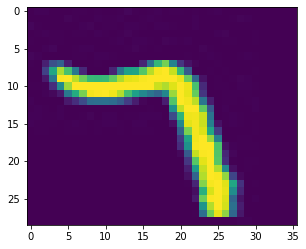

In [10]:
trainbk = []
for epoch in range(10):

    total_loss = 0
    model.train()
    for i,traindata in enumerate(trainloader):
        inputs = traindata[0]
        gts = traindata[1]
        X = inputs.to(device)
        gt = gts.to(device)
        optimizer_ft.zero_grad()
        outputs = model(X)
        loss = loss_function(outputs,gt, 1)
        loss.backward()
        optimizer_ft.step()
        total_loss += loss
        trainbk.append(loss)
        if (i+1)%100 == 0:
            print(f'{loss} step{i}/{trainnum}')
            sample_show(outputs,gt,1,i,epoch)
    print(total_loss)

### Loss 下降情况

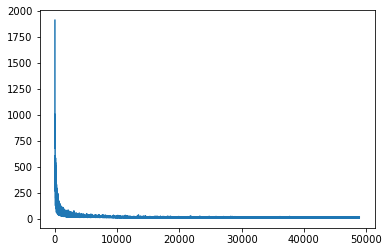

In [11]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(range(len(trainbk)),trainbk,label = "train loss")

### Mnist results

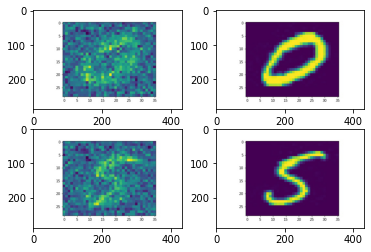

In [48]:
path1 = r"D:\lwr\figs\5_4399.jpg"
path2 = r"D:\lwr\figs\gts\5_4399.jpg"

path5 = r"D:\lwr\figs\5_4599.jpg"
path6 = r"D:\lwr\figs\gts\5_4599.jpg"

plt.figure()
plt.subplot(2,2,1)
plt.imshow(plt.imread(path1))
plt.subplot(2,2,2)
plt.imshow(plt.imread(path2))
plt.subplot(2,2,3)
plt.imshow(plt.imread(path5))
plt.subplot(2,2,4)
plt.imshow(plt.imread(path6))


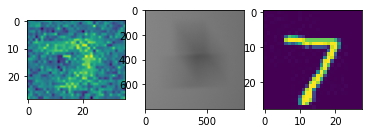

In [57]:

test_path = r"D:\lwr\MNIST_data\otherrender\test_0_7.png"
test_tensor = rendered_loader(test_path)
inp = test_tensor.view(1,3,224,224).to(device)
output = model(inp)
sample = torch.matmul(B_T,torch.matmul(R,output.view(512)))
sample_np = sample.cpu().detach().view(29,36).numpy()
plt.figure("sample")
plt.subplot(1,3,1)
plt.imshow(sample_np)
plt.subplot(1,3,2)
image = mpimg.imread(test_path)
plt.imshow(image)
plt.subplot(1,3,3)
plt.imshow(mpimg.imread(r"D:\lwr\MNIST_data\test_images\test_0_7.jpg"))

### RGB bars 测试

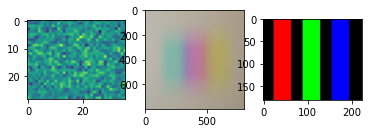

In [49]:

test_path = r"D:\lwr\figs\test\res2.png"
test_tensor = rendered_loader(test_path)
inp = test_tensor.view(1,3,224,224).to(device)
output = model(inp)
sample = torch.matmul(B_T,torch.matmul(R,output.view(512)))
sample_np = sample.cpu().detach().view(29,36).numpy()
plt.figure("sample")
plt.subplot(1,3,1)
plt.imshow(sample_np)
plt.subplot(1,3,2)
image = mpimg.imread(test_path)
plt.imshow(image)
plt.subplot(1,3,3)
plt.imshow(mpimg.imread(r"D:\lwr\figs\gts\gt.jpg"))

### 黑白图测试

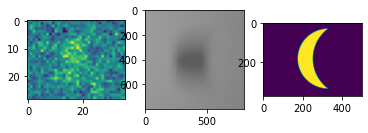

In [51]:
test_path = r"D:\lwr\MNIST_data\otherrender\train\50e8e313d27742336bec497114fa91df.png"
test_tensor = rendered_loader(test_path)
inp = test_tensor.view(1,3,224,224).to(device)
output = model(inp)
sample = torch.matmul(B_T,torch.matmul(R,output.view(512)))
sample_np = sample.cpu().detach().view(29,36).numpy()
plt.figure("sample")
plt.subplot(1,3,1)
plt.imshow(sample_np)
plt.subplot(1,3,2)
image = mpimg.imread(test_path)
plt.imshow(image)
plt.subplot(1,3,3)
plt.imshow(mpimg.imread(r"D:\lwr\MNIST_data\other\50e8e313d27742336bec497114fa91df.jpg"))

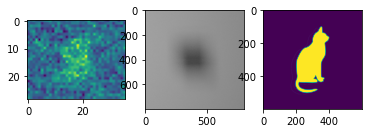

In [55]:
test_path = r"D:\lwr\MNIST_data\otherrender\train\fd5939cf2383b02bf7184a3b9c370f1d.png"
test_tensor = rendered_loader(test_path)
inp = test_tensor.view(1,3,224,224).to(device)
output = model(inp)
sample = torch.matmul(B_T,torch.matmul(R,output.view(512)))
sample_np = sample.cpu().detach().view(29,36).numpy()
plt.figure("sample")
plt.subplot(1,3,1)
plt.imshow(sample_np)
plt.subplot(1,3,2)
image = mpimg.imread(test_path)
plt.imshow(image
plt.subplot(1,3,3)
plt.imshow(mpimg.imread(r"D:\lwr\MNIST_data\other\fd5939cf2383b02bf7184a3b9c370f1d.jpeg"))